# UP42 Satellite Image Ordering 101

Building on a [previous](https://up42.com/blog/tech/webhooks-exploring-local-developments-openresty) article, this notebook provides a recipe for:

 1. Searching for data.
 2. Ordering the selected data.
 3. Get notified via a webhook when the order(s) get(s) delivered.

**N.B.**: Make sure you are using a version  **$\ge$ 0.22.0**. This is the version where support for webhooks was introduced.

## Installing the UP42 Python SDK

The module is called `up42`. Python **>= 3.8** is **required**.

 1. Create a virtual environment.
```bash
 mkvirtualenv --python=$(which python3) up42-py
```
 2. Activate the environment.
```bash
 workon up42-py
```
 3. Install the module.
 ```bash
 pip install up42-py
 ```
 4. Install Jupyter Lab.
```bash
 pip install jupyterlab
 ```
 5. Done.
 
Now we can just import it.

In [1]:
import up42

## Authenticate with project ID and project key
The project API key and the project ID are read from a JSON file. This file has the following structure:
```
{
  "project_id": "<your-project-ID-here>",
  "project_api_key": "<your-api-key-here>"
}
```
To find out how to obtain the project API key and project ID the please refer to the [documentation](https://docs.up42.com/processing-platform/projects#developers)

Reading the credentials from the JSON file `~/.up42/proj_default.json`.

In [2]:
from pathlib import Path

project_config_file = Path.home() / ".up42" / "proj_default.json"
up42.authenticate(cfg_file=project_config_file)

2023-07-07 11:13:51,155 - Got credentials from config file.
2023-07-07 11:13:51,881 - Authentication with UP42 successful!


## Create a webhook for handling order statuses

First we look at the available notifiable events.

We just invoke the [`get_webhook_events`](https://sdk.up42.com/reference/webhooks-reference/#up42.webhooks.Webhooks.get_webhook_events) method.

In [3]:
up42.get_webhook_events()

[{'name': 'job.status',
  'title': 'Job Status Updates',
  'category': 'job',
  'description': 'Sent when job/task status is updated',
  'documentation': 'https://docs.up42.com/developers/'},
 {'name': 'order.status',
  'title': 'Order Status Updates',
  'category': 'order',
  'description': 'Sent when order status is updated',
  'documentation': 'https://docs.up42.com/developers/'}]

There are two types of events: `job.status` for notifying about jobs and `order.status` for notifiyng about orders. Since this notebooks deals with orders *solely* is the `order.status` event that we are interested in.  

## Create the webhook

We want now to manipulate a specific webhook. For that we build a list of `(<name>, <id>)` tuples for each webhook.
Let us first define the secret. 

**N.B.** This is just an example. Choosw one secret that is hard to guess and up to **500** characters long.

In [8]:
wh_order101_secret = "the mighty fox jumped over the normal lazy dog"

In order to differentiate the webhook every time you run this cell or the full notebook we are going to add a date string to the workflow name. This string has the form: `yyyymmddhhmmss`.

In [9]:
import datetime as dt
now_str = dt.datetime.now().strftime("%Y%m%d%H%M%S")

In [10]:
wh_order101 = up42.create_webhook(
    name="ordering 101 webhook" + "-" + now_str,
    url="https://eophenon9705lt2.m.pipedream.net",
    events=["order.status"],
    secret=wh_order101_secret,
)

2023-07-07 11:15:51,368 - Created webhook Webhook(name: ordering 101 webhook-20230707111549, webhook_id: 92bc9d67-3514-49d2-950a-8d69a1d13ff5, active: False


The webhook is not active **yet**. First we want to test it.

Let us now see what methods we have available. We are going to use a small module with helper functions.

We want to list all the non-magic methods that this class posesses. Somewhat similar to Julia's [methodswith](https://docs.julialang.org/en/v1/stdlib/InteractiveUtils/#InteractiveUtils.methodswith).

In [5]:
# N.B: This is an ugly hack that needs to be replaced by creating a proper local Python package for the Notebook helpers.
import sys
sys.path.append(str((Path.cwd() / ".." / "..").resolve()))

In [11]:
import pynb_helpers.misc as misc

misc.methods(type(wh_order101))

[('trigger_test_events', <Signature (self) -> dict>),
 ('update',
  <Signature (self, name: Optional[str] = None, url: Optional[str] = None, events: Optional[List[str]] = None, active: Optional[bool] = None, secret: Optional[str] = None) -> 'Webhook'>),
 ('delete', <Signature (self) -> None>)]

## Testing the webhook

Before we proceed we want to [test](https://docs.up42.com/developers/api#operation/runWebhookTests) the webhook. We already know the name and signature of the function. Is named `trigger_test_events` and takes no arguments.

In [9]:
wh_order101.trigger_test_events()

{'startedAt': '2023-01-09T03:34:52.266344Z',
 'testsRun': 1,
 'testsSucceeded': 1,
 'testsFailed': 0,
 'tests': [{'startedAt': '2023-01-09T03:34:52.735495Z',
   'eventName': 'order.status',
   'success': True,
   'message': 'Test request was successful!',
   'request': {'headers': {'caseInsensitiveName': True, 'empty': False},
    'body': {'event': 'order.status',
     'liveMode': False,
     'messageId': '5f290b80-d8d7-4d1c-bbe6-626d4f00dad3',
     'timestamp': '2023-01-09T03:34:52.267042Z',
     'body': {'orderId': '00000000-0000-0000-0000-000000000001',
      'orderType': 'TASKING',
      'dataHostName': 'test-up42-host-name',
      'status': 'FULFILLED',
      'statusIsFinal': True}}},
   'response': 'HttpResponse[https://eophenon9705lt2.m.pipedream.net/, 200 OK]'}]}

Now that we tested the webhook we proceed to the ordering.

## Searching for data

We now look for existing data in the region we are interested in. The AOI is defined via a GeoJSON file in the `examples` directory. Let us use [ipyleaflet](https://ipyleaflet.readthedocs.io/) to visualize it.

In [12]:
from ipyleaflet import Map, GeoJSON

In [13]:
# Path to the AOI GeoJSON.
path2aoi = "../examples/portinho_arrabida.geojson"

In [14]:
import json

with open(path2aoi, "r") as f:
    aoi_map = json.load(f)

### Drawing the AOI in a map

In [15]:
map = Map(center=(38.47064394226866, -8.984506813116552), zoom=14)

# Add the AOI to the map. First style it and then add it.
aoi_layer = GeoJSON(
    data=aoi_map,
    style={"opacity": 1, "dashArray": "9", "fillOpacity": 0.5, "weight": 1},
    hover_style={"color": "yellow", "dashArray": "0", "fillOpacity": 0.5},
)
map.add_layer(aoi_layer)
map

Map(center=[38.47064394226866, -8.984506813116552], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Searching for data in the catalog

We need to instantiate a catalog object and perform a [search](https://sdk.up42.com/search_order/#search-image-in-the-catalog).

In [21]:
catalog = up42.initialize_catalog()

#### Getting the display product ID

Before performing the search we need to select the data product we are interested in. In this case we are interested in a display product of a Pléiades image. The data product we want is not necessary for the search itself, but we do it now so that the ordering flow stays simple. Since we do the data product selection at the outset and not after performing the search. This reproduces the usual actions of having the product specified before hand and then performing the search.

In [22]:
products = catalog.get_data_products(basic=True)
products

{'Near Space Labs': {'collection': 'nsl-30cm',
  'host': 'nearspacelabs',
  'data_products': {'Display Full Scene': '7131f727-cdbb-46d4-a1e7-77ac38b7bd02'}},
 'Capella Space GEC': {'collection': 'capella-gec',
  'host': 'capellaspace',
  'data_products': {'Full Scene': '96072809-d820-4cf9-86dd-d3bff3337c35'}},
 'Capella Space GEO': {'collection': 'capella-geo',
  'host': 'capellaspace',
  'data_products': {'Full Scene': 'd66facaa-533f-49a2-849a-c2910ac9dd31'}},
 'Capella Space SICD': {'collection': 'capella-sicd',
  'host': 'capellaspace',
  'data_products': {'Full Scene': '8b0aed07-c565-4bf9-b719-401e692de4a6'}},
 'Capella Space SLC': {'collection': 'capella-slc',
  'host': 'capellaspace',
  'data_products': {'Full Scene': '1f2b0d7f-d3e2-4b3d-96b7-e7c184df7952'}},
 'Pléiades Neo': {'collection': 'pneo',
  'host': 'oneatlas',
  'data_products': {'Analytic': '6f722fb5-0323-4c97-9b1e-22870325b8db',
   'Display': '17745de8-6e7d-4751-99cd-3f8e9e9d290e'}},
 'SPOT': {'collection': 'spot',
  

Let us list the name of the available archive data collections from Airbus hosted by OneAtlas.

In [16]:
list(filter(lambda e: e[1]["host"] == "oneatlas", products.items()))

[('Pléiades Neo',
  {'collection': 'pneo',
   'host': 'oneatlas',
   'data_products': {'Analytic': '6f722fb5-0323-4c97-9b1e-22870325b8db',
    'Display': '17745de8-6e7d-4751-99cd-3f8e9e9d290e'}}),
 ('SPOT 6/7',
  {'collection': 'spot',
   'host': 'oneatlas',
   'data_products': {'Analytic': 'b1f8c48e-d16b-44c4-a1bb-5e8a24892e69',
    'Display': 'acc3f9a4-b622-49c1-b1e1-c762aa3e7e13'}}),
 ('Pléiades',
  {'collection': 'phr',
   'host': 'oneatlas',
   'data_products': {'Analytic': '4f1b2f62-98df-4c74-81f4-5dce45deee99',
    'Display': '647780db-5a06-4b61-b525-577a8b68bb54'}})]

We are interested in images from the **Pléiades** optical satellite constellation: 50 cm resolution. I.e., the archive collection named `phr` and the `Display` product.

In [18]:
phr_product = next(filter(lambda e: e[1]["collection"] == "phr", products.items()))
phr_product

('Pléiades',
 {'collection': 'phr',
  'host': 'oneatlas',
  'data_products': {'Analytic': '4f1b2f62-98df-4c74-81f4-5dce45deee99',
   'Display': '647780db-5a06-4b61-b525-577a8b68bb54'}})

In [23]:
phr_product_id = phr_product[1]["data_products"]["Display"]
phr_product_id

'647780db-5a06-4b61-b525-577a8b68bb54'

Now that we have the product ID we'll need later when placing the order let us proceed to the search.

We are looking for Pléiades archive images acquired in 2022 and with a cloud coverage of at most 10%.

In [24]:
search_params = catalog.construct_search_parameters(
    geometry=aoi_map,
    start_date="2022-01-01",
    end_date="2023-12-31",
    collections=["phr"],
    max_cloudcover=10,
    sortby="acquisitionDate",
    ascending=False,
    limit=10,
)

NotImplementedError: A polygon does not itself provide the array interface. Its rings do.

In [20]:
search_results = catalog.search(search_parameters=search_params)

2023-01-09 04:35:48,473 - Searching catalog with search_parameters: {'datetime': '2022-01-01T00:00:00Z/2022-12-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-8.970508575439453, 38.48382914339068), (-8.98106575012207, 38.48141037533113), (-8.989777565002441, 38.47637101450613), (-8.992223739624023, 38.47015531764655), (-8.991966247558594, 38.46561920067743), (-8.990163803100586, 38.465518394837304), (-8.990421295166016, 38.46709767014416), (-8.986902236938477, 38.46978571879323), (-8.982696533203125, 38.47381760389001), (-8.984713554382324, 38.47600144751436), (-8.981409072875977, 38.47905871745382), (-8.97707462310791, 38.48026815108751), (-8.971881866455078, 38.48016736572641), (-8.96934986114502, 38.480604101273386), (-8.969564437866211, 38.481746320193345), (-8.968620300292969, 38.48208226348981), (-8.969006538391113, 38.48288852101284), (-8.970508575439453, 38.48382914339068)),)}, 'limit': 10, 'collections': ['phr'], 'query': {'cloudCoverage': {'lte': 10}}, 'so

In [21]:
search_results

,geometry,id,constellation,collection,providerName,up42:usageType,providerProperties,sceneId,producer,acquisitionDate,start_datetime,end_datetime,cloudCoverage,resolution,deliveryTime
0,"POLYGON ((-9.07979 38.54479, -9.07942 38.37225...",0fd1e2bc-ea71-4c8c-876b-cb6a6b9983de,phr,phr,oneatlas,[DATA],"{'commercialReference': 'SO22053139', 'qualifi...",0fd1e2bc-ea71-4c8c-876b-cb6a6b9983de,airbus,2022-09-09T11:28:49.681Z,None,None,2.26,0.5,MINUTES
1,"POLYGON ((-9.07957 38.37160, -9.00613 38.37198...",2fd331b8-3c59-4f20-9312-9e9114d41409,phr,phr,oneatlas,[DATA],"{'qualified': False, 'sourceIdentifier': 'DS_P...",2fd331b8-3c59-4f20-9312-9e9114d41409,airbus,2022-09-09T11:28:49.681Z,None,None,2.10,0.5,HOURS
2,"POLYGON ((-9.08728 39.19341, -9.08412 38.36209...",2a2b6c0d-ef0a-4aac-9c0d-e55957e5fd1a,phr,phr,oneatlas,[DATA],"{'commercialReference': 'SO22013070', 'qualifi...",2a2b6c0d-ef0a-4aac-9c0d-e55957e5fd1a,airbus,2022-03-18T11:24:06.055Z,None,None,6.70,0.5,MINUTES


We found *three* (3) images. In this case we want the first result returned. Let us obtain the quicklook for it (low resolution bitmap image preview).

2023-01-09 04:35:58,563 - Downloading quicklooks from provider oneatlas.
2023-01-09 04:35:58,567 - Download directory: /Users/appa/up42/data-recipes/data-ordering101/notebooks/project_0bf107a0-21a3-46cc-85bb-7ff721098d65/catalog
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


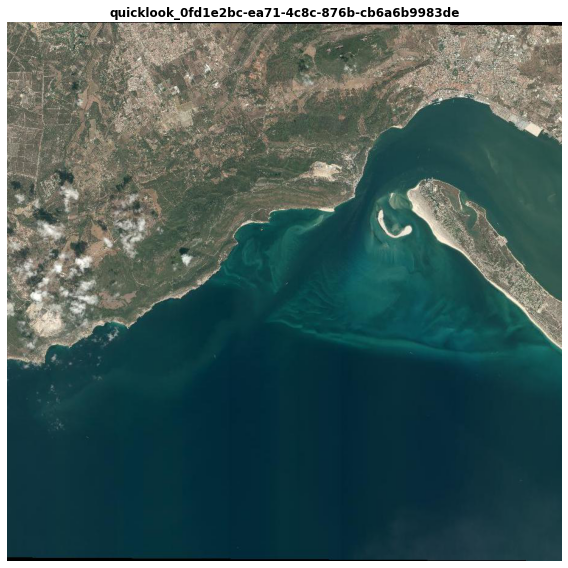

In [22]:
catalog.download_quicklooks(search_results.iloc[0].id, collection="phr")
catalog.plot_quicklooks()

The quicklooks is always for the full scene.

## Placing the order

Now that we have chosen the image we want to order it. And we want to be notified when the order gets fulfilled. So before we place the order we need to activate the webhook we created above.

### Activating the webhook

Let us inspect the webhook settings/parameters.

In [23]:
wh_order101.__dict__

{'auth': UP42ProjectAuth(project_id=0bf107a0-21a3-46cc-85bb-7ff721098d65),
 'workspace_id': 'd39fe05a-400c-44f6-b770-86990f64b004',
 'webhook_id': 'd7fe638c-5801-440c-9fb1-c19a390a75e6',
 '_info': {'url': 'https://eophenon9705lt2.m.pipedream.net',
  'name': 'ordering 101 webhook-20230109043256',
  'active': False,
  'events': ['order.status'],
  'id': 'd7fe638c-5801-440c-9fb1-c19a390a75e6',
  'secret': 'the mighty fox jumped over the normal lazy dog',
  'createdAt': '2023-01-09T03:33:02.013459Z',
  'updatedAt': '2023-01-09T03:33:02.013459Z'}}

In [24]:
wh_order101.__dict__["_info"]

{'url': 'https://eophenon9705lt2.m.pipedream.net',
 'name': 'ordering 101 webhook-20230109043256',
 'active': False,
 'events': ['order.status'],
 'id': 'd7fe638c-5801-440c-9fb1-c19a390a75e6',
 'secret': 'the mighty fox jumped over the normal lazy dog',
 'createdAt': '2023-01-09T03:33:02.013459Z',
 'updatedAt': '2023-01-09T03:33:02.013459Z'}

We need to [update](https://sdk.up42.com/reference/webhooks-reference/#up42.webhooks.Webhook.update) this webhook.

In [27]:
wh_order101.update(
    name="ordering 101 webhook" + "-" + now_str,
    url=wh_order101.__dict__["_info"]["url"],
    events=wh_order101.__dict__["_info"]["events"],
    active=True,
    secret=wh_order101.__dict__["_info"]["secret"],
)

2023-01-09 04:37:13,015 - Updated webhook Webhook(name: ordering 101 webhook-20230109043256, webhook_id: d7fe638c-5801-440c-9fb1-c19a390a75e6, active: True


Webhook(name: ordering 101 webhook-20230109043256, webhook_id: d7fe638c-5801-440c-9fb1-c19a390a75e6, active: True

Let us check the webhook settings now.

In [28]:
wh_order101.__dict__["_info"]

{'url': 'https://eophenon9705lt2.m.pipedream.net',
 'name': 'ordering 101 webhook-20230109043256',
 'active': True,
 'events': ['order.status'],
 'id': 'd7fe638c-5801-440c-9fb1-c19a390a75e6',
 'secret': 'the mighty fox jumped over the normal lazy dog',
 'createdAt': '2023-01-09T03:33:02.013459Z',
 'updatedAt': '2023-01-09T03:37:13.052715Z'}

We see that the webhook is now **active**.

### Placing the order

Now to [order](https://sdk.up42.com/search_order/#order-the-image) the image we use the first data frame returned by the search. We have all we need to create the order parameters:
 * product ID
 * image ID
 * AOI

In [57]:
order_params = catalog.construct_order_parameters(
    data_product_id=phr_product_id, image_id=search_results.iloc[0].id, aoi=aoi_map
)

2022-10-25 17:10:15,606 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.


#### Estimating the order

We estimate the cost of the order.

In [58]:
catalog.estimate_order(order_params)

2022-10-25 17:10:24,080 - Order is estimated to cost 1010 UP42 credits (order_parameters: {'dataProduct': '647780db-5a06-4b61-b525-577a8b68bb54', 'params': {'id': '0fd1e2bc-ea71-4c8c-876b-cb6a6b9983de', 'aoi': {'type': 'Polygon', 'coordinates': (((-8.970508575439453, 38.48382914339068), (-8.98106575012207, 38.48141037533113), (-8.989777565002441, 38.47637101450613), (-8.992223739624023, 38.47015531764655), (-8.991966247558594, 38.46561920067743), (-8.990163803100586, 38.465518394837304), (-8.990421295166016, 38.46709767014416), (-8.986902236938477, 38.46978571879323), (-8.982696533203125, 38.47381760389001), (-8.984713554382324, 38.47600144751436), (-8.981409072875977, 38.47905871745382), (-8.97707462310791, 38.48026815108751), (-8.971881866455078, 38.48016736572641), (-8.96934986114502, 38.480604101273386), (-8.969564437866211, 38.481746320193345), (-8.968620300292969, 38.48208226348981), (-8.969006538391113, 38.48288852101284), (-8.970508575439453, 38.48382914339068)),)}}})


1010

The cost is going to be **1010** credits, i.e., **10.1** EUR.

#### Ordering

Finally we place the order.

In [47]:
order101 = catalog.place_order(order_params)

2022-10-25 16:55:02,845 - Order is PLACED
2022-10-25 16:55:02,848 - Order f3b4d9fd-7504-49dc-8d13-abc56d021d16 is now PLACED.


Order(order_id: f3b4d9fd-7504-49dc-8d13-abc56d021d16, assets: [], dataProvider: None, status: PLACED, createdAt: 2022-10-25T14:54:58.727813Z, updatedAt: 2022-10-25T14:55:01.632082Z)

We see that the order was placed. Now let us wait for the webhook notification relative to it.

## Checking for order completion with webhooks & nginx

We need to load the [JSON lines](https://jsonlines.org/) (JSONL) file into the notebook and handle it as a data frame. First we need to import the helper functions to handle JSONL files.

In [48]:
from pynb_helpers import jsonl_io as jslio

### Checking the webhook nginx log file

The (JSONL) log file where the notifications from the webhook we created above are. Let us load it.

In [49]:
jsonl_logs_file = "../log/up42_order_log.jsonl"

In [50]:
log_data = jslio.load_jsonl(jsonl_logs_file)

Loaded 1 records from ../log/up42_order_log.jsonl.
Loaded 2 records from ../log/up42_order_log.jsonl.
Loaded 3 records from ../log/up42_order_log.jsonl.
Loaded 4 records from ../log/up42_order_log.jsonl.
Loaded 5 records from ../log/up42_order_log.jsonl.
Loaded 6 records from ../log/up42_order_log.jsonl.
Loaded 7 records from ../log/up42_order_log.jsonl.
Loaded 8 records from ../log/up42_order_log.jsonl.
Loaded 9 records from ../log/up42_order_log.jsonl.
Loaded 10 records from ../log/up42_order_log.jsonl.


Let us now read it into a data frame.

In [51]:
import pandas as pd

In [52]:
db_data = []
db_cols = ["date", "order_id", "status"]
for d in log_data:
    db_data.append([])
    for col in db_cols:
        db_data[-1].append(d[db_cols.index(col)])

df = pd.DataFrame(db_data, columns=db_cols)

In [53]:
df

,date,order_id,status
0,"Monday, 08-Aug-2022 17:09:15 UTC",044abd68-9b17-4424-a0a7-80f4650b93c2,FULLFILED
1,"Monday, 08-Aug-2022 17:10:12 UTC",ea0d0e66-3f2c-4bb9-9b44-86bee49b9f4f,FULLFILED
2,"Monday, 08-Aug-2022 17:15:24 UTC",09951ac9-8170-4388-a947-e25733ff03ba,FULFILLED
3,"Monday, 08-Aug-2022 17:15:34 UTC",68022767-1e13-492f-83e9-4780636fe10f,FULFILLED
4,"Wednesday, 10-Aug-2022 16:42:18 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
5,"Wednesday, 10-Aug-2022 16:43:43 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
6,"Wednesday, 10-Aug-2022 16:44:23 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
7,"Thursday, 11-Aug-2022 05:01:36 UTC",92ceac2c-a89f-4e66-9a8d-b20f336d8799,FULFILLED
8,"Tuesday, 25-Oct-2022 12:23:34 UTC",00000000-0000-0000-0000-000000000001,FULFILLED
9,"Tuesday, 25-Oct-2022 14:58:37 UTC",f3b4d9fd-7504-49dc-8d13-abc56d021d16,FULFILLED


The order we are interested is in the last row.

In [55]:
df.iloc[-1]

date           Tuesday, 25-Oct-2022 14:58:37 UTC
order_id    f3b4d9fd-7504-49dc-8d13-abc56d021d16
status                                 FULFILLED
Name: 9, dtype: object

## Getting the asset associated with the order



In [70]:
assets101 = order101.get_assets()

2022-10-25 17:28:39,524 - Order is FULFILLED


In [71]:
len(assets101)

1

There is only one asset, as expected, since there was only a single item returned by the search.

In [72]:
assets101[0].__dict__

{'auth': UP42ProjectAuth(project_id=5ea6a20d-4fa9-42a1-8e29-f2d9b27b0097, env=com),
 'workspace_id': 'd39fe05a-400c-44f6-b770-86990f64b004',
 'asset_id': 'f5080d5d-cb90-4cb5-9caf-b1e870865967',
 'results': None,
 '_info': {'id': 'f5080d5d-cb90-4cb5-9caf-b1e870865967',
  'workspaceId': 'd39fe05a-400c-44f6-b770-86990f64b004',
  'createdAt': '2022-10-25T14:58:28.139788Z',
  'type': 'ARCHIVED',
  'source': 'ORDER',
  'name': 'oneatlas_f3b4d9fd-7504-49dc-8d13-abc56d021d16.zip',
  'size': 14024332,
  'metadata': {'geometry': {'type': 'Polygon',
    'coordinates': [[[-8.969006538391113, 38.48288852101284],
      [-8.970508575439453, 38.48382914339068],
      [-8.98106575012207, 38.48141037533113],
      [-8.989777565002441, 38.47637101450613],
      [-8.992223739624023, 38.47015531764655],
      [-8.991966247558594, 38.46561920067743],
      [-8.990163803100586, 38.465518394837304],
      [-8.990421295166016, 38.46709767014416],
      [-8.986902236938477, 38.46978571879323],
      [-8.9826965

The asset ID is:

In [73]:
assets101[0].asset_id

'f5080d5d-cb90-4cb5-9caf-b1e870865967'

Next step is to download this asset from the UP42 [Storage](https://sdk.up42.com/storage/#access-download-assets).

## Download the asset

In [74]:
assets101[0].download(unpacking=False, output_directory=Path("..") / "examples")

2022-10-25 17:30:31,189 - Downloading asset f5080d5d-cb90-4cb5-9caf-b1e870865967
2022-10-25 17:30:31,191 - Download directory: ../examples
13696it [00:01, 8684.60it/s]
2022-10-25 17:30:33,187 - Download successful of original archive file to output_directory '../examples': output.zip. To automatically unpack the archive use `unpacking=True`


['../examples/output.zip']

Now that we have the image our next steps would be visualizing and/or processing it. The ordering process is now **concluded**.